In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ZeroMean
from gpytorch.kernels import  MaternKernel, RBFKernel

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 20,
})

In [3]:
# Create the Gaussian Process model following the example: https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html

class MyGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, mean_function, kernel):
        super(MyGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = mean_function
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def train_GPR(x_train, y_train,kernel, mean_function, likelihood, epochs):
    l=[]

    model = MyGPModel(x_train, y_train, likelihood, mean_function, kernel)

    # Training the model
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Use Adam optimizer

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model) # Marginal Log Likelihood - https://docs.gpytorch.ai/en/latest/_modules/gpytorch/mlls/exact_marginal_log_likelihood.html

    # Training loop
    for i in range(epochs):

        optimizer.zero_grad()
        output = model(x_train)
        loss = -mll(output, y_train)
        l+= [loss.item()]

        loss.backward()
        optimizer.step()

        print('\n******* Iteration {} *******'.format(i+1))

        for param_name, param in model.named_parameters():
            print(f'Parameter name: {param_name:42} value = {param.item()}')

        print(f'Epoch {i+1}/{epochs}, Loss: {loss.item()}')
        
    return model, l

def make_predictions(model, test_x, likelihood):
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))
        var = observed_pred.variance # Get the variance from the predictive distribution and set the bounds manually
        lower, upper = observed_pred.confidence_region() # Get the bounds from the predictive distribution
        return observed_pred, lower, upper,var

def plot_predictions(x_train, y_train,test_x, observed_pred, lower, upper):
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 6))
    # Plot training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    # ax.fill_between(test_x.numpy(), observed_pred.mean.numpy()-1.96*np.sqrt(lower.numpy()), observed_pred.mean.numpy()+1.96*np.sqrt(upper.numpy()), alpha=0.5) # with manual variance
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

In [4]:
# x_train = np.array([-4.3, -4.6, -4.8, -3.1, -1.4, -5.6, -6.8, -4.1, -0.5, -2.4, -4.9, -3.6, -8.2, -5.9, -4.0,
#                     -8.5, -8.6, -0.6, -7.0, -7.4, -2.6, -2.9, -9.7, -2.2, -8.1, -1.9, -5.3, -6.7, -8.0, -0.4,
#                     -3.5, -5.8, -2.3, -1.5, -9.8, 10.0, 10.2, 10.1, 10.6, 9.5, -6.8, -7.0, -6.8, -6.9, -6.8]
#                    ).reshape((-1, 1))
# y_train = np.array([-0.6, 0.0, 0.2, -1.8, -1.7, 1.3, 1.8, -0.6, -0.6, -2.2, 0.3, -1.2, 1.5, 1.5, -1.1, 1.1, 1.4,
#                     -0.7, 2.1, 1.8, -1.8, -1.9, -0.1, -2.1, 1.6, -1.9, 0.5, 1.5, 1.3, -0.7, -1.3, 1.6, -2.2, -1.6,
#                     -0.3, 0.7, 1.1, 0.9, 1.0, 0.6, 2.0, 1.9, 1.9, 2.1, 1.9]).reshape((-1,1))

x_train = np.load("/Users/ozgeozbayram/Desktop/GP_heteroscedastic/X_train.npy")
y_train = np.load("/Users/ozgeozbayram/Desktop/GP_heteroscedastic/Y_train.npy")

X = torch.from_numpy(x_train).double()
Y = torch.from_numpy(y_train).double().squeeze(-1)

X_t = torch.linspace(float(min(X).item()), float(max(X).item()), 100, dtype=torch.float64).unsqueeze(-1)


******* Iteration 1 *******
Parameter name: likelihood.noise_covar.raw_noise           value = 0.09999999403953552
Parameter name: covar_module.raw_lengthscale               value = 0.09999996423721313
Epoch 1/200, Loss: 1.5810628056117357

******* Iteration 2 *******
Parameter name: likelihood.noise_covar.raw_noise           value = 0.19854046404361725
Parameter name: covar_module.raw_lengthscale               value = 0.19992658495903015
Epoch 2/200, Loss: 1.5647130072937678

******* Iteration 3 *******
Parameter name: likelihood.noise_covar.raw_noise           value = 0.2942916750907898
Parameter name: covar_module.raw_lengthscale               value = 0.29963165521621704
Epoch 3/200, Loss: 1.551675261296976

******* Iteration 4 *******
Parameter name: likelihood.noise_covar.raw_noise           value = 0.38568246364593506
Parameter name: covar_module.raw_lengthscale               value = 0.39891037344932556
Epoch 4/200, Loss: 1.541674428107473

******* Iteration 5 *******
Parameter 

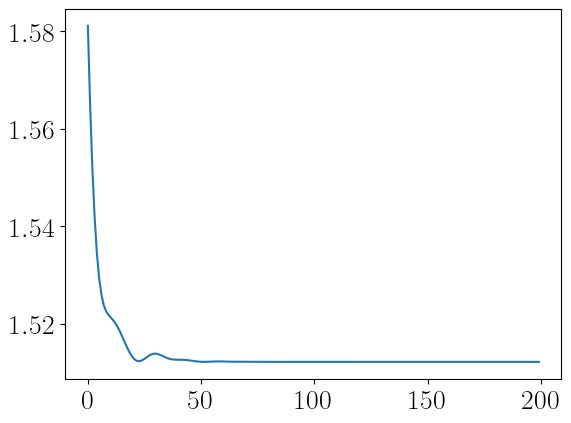

In [5]:
likelihood = GaussianLikelihood() # https://docs.gpytorch.ai/en/latest/_modules/gpytorch/likelihoods/gaussian_likelihood.html
mean_function = ZeroMean()
kernel = MaternKernel(nu=1.5)

num_iter = 200

model, l = train_GPR(X,Y,kernel, mean_function, likelihood, num_iter)

plt.plot(l)
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

observed_pred, lower, upper,var = make_predictions(model, X_t, likelihood)

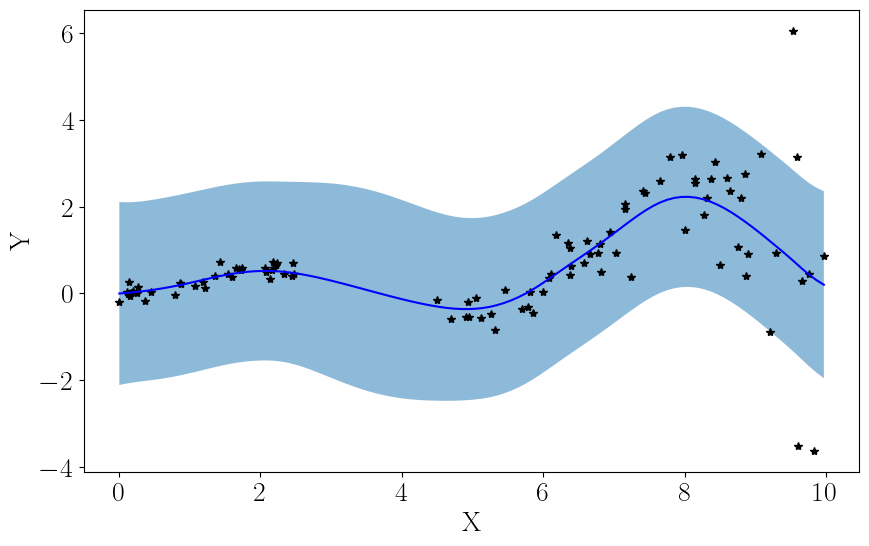

Kernel parameters: lenghtscale = Parameter containing:
tensor([[1.7032]], requires_grad=True), noise_var= Parameter containing:
tensor([0.5518], requires_grad=True), exp_noise_var= tensor([1.7364], grad_fn=<ExpBackward0>)


In [6]:
plot_predictions(X,Y,X_t.squeeze(-1), observed_pred, lower, upper)
# get model parameters and print them
print(f"Kernel parameters: lenghtscale = {model.covar_module.raw_lengthscale}, noise_var= {model.likelihood.noise_covar.raw_noise}, exp_noise_var= {torch.exp(model.likelihood.noise_covar.raw_noise)}")